In [ ]:
pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset (20 Newsgroups)
dataset = load_dataset("SetFit/20_newsgroups", split="train")

# Select two categories for binary classification
categories = ["rec.sport.baseball", "sci.space"]
filtered_data = [d for d in dataset if d["label_text"] in categories]

# Map labels to binary values
label_map = {categories[0]: 0, categories[1]: 1}
texts = [d["text"] for d in filtered_data]
labels = [label_map[d["label_text"]] for d in filtered_data]

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(
        texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt"
    )

# Tokenize dataset
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# PyTorch Dataset class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch datasets
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

# Load BERT model for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, val_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss, correct = 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
        evaluate_model(model, val_loader)

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(true_labels, predictions))

# Train the model
train_model(model, train_loader, val_loader, epochs=3)

# Save model
model.save_pretrained("bert_newsgroup_classifier")
tokenizer.save_pretrained("bert_newsgroup_classifier")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-2ea5658b341c>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Loss: 0.2136
Validation Accuracy: 0.9538
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       120
           1       0.98      0.92      0.95       118

    accuracy                           0.95       238
   macro avg       0.96      0.95      0.95       238
weighted avg       0.96      0.95      0.95       238



<ipython-input-6-2ea5658b341c>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 2, Loss: 0.0642
Validation Accuracy: 0.9412
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       120
           1       0.93      0.96      0.94       118

    accuracy                           0.94       238
   macro avg       0.94      0.94      0.94       238
weighted avg       0.94      0.94      0.94       238



<ipython-input-6-2ea5658b341c>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 3, Loss: 0.0323
Validation Accuracy: 0.9538
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       120
           1       0.96      0.95      0.95       118

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



('bert_newsgroup_classifier/tokenizer_config.json',
 'bert_newsgroup_classifier/special_tokens_map.json',
 'bert_newsgroup_classifier/vocab.txt',
 'bert_newsgroup_classifier/added_tokens.json')

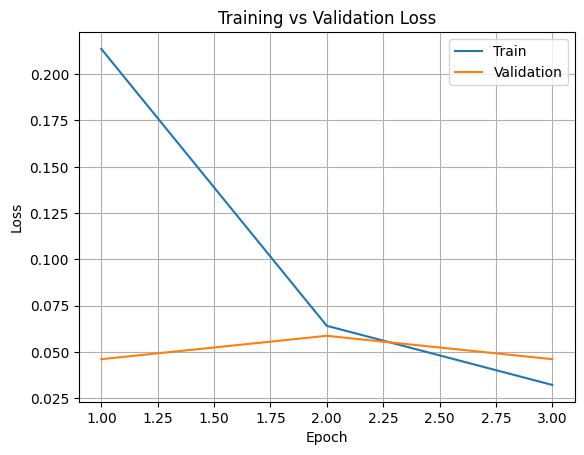

In [ ]:
import matplotlib.pyplot as plt

# Example loss lists (replace these with your actual losses)
train_losses = [0.2136, 0.0642, 0.0323]
val_losses = [0.0462, 0.0588, 0.0462]

# Plotting training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Question and Answers:
1. What is a Transformer model, and how does it differ from RNNs?
   
   Transformers are models built to handle entire sequences at once using something called attention, rather than going word by word like RNNs do. That means they can understand the full context of a sentence instantly, which makes them faster and more accurate. Unlike RNNs, they don’t struggle with long sequences or forget earlier words. This parallel processing is a big deal because it speeds up training and makes Transformers great for complex language tasks.

2. Explain the concept of self-attention and why it significantly improves NLP
   tasks.
   
   Self-attention is a clever technique where the model figures out which words in a sentence relate to each other the most. So, if you have a long sentence, the model can still focus on the important parts, no matter how far apart they are. This makes understanding things like grammar, meaning, or tone much easier. It helps the model understand deeper relationships between words, which improves performance on almost any language-related task.

3. Discuss why fine-tuning pretrained Transformer models is effective compared to training from scratch.
   
   Training a Transformer from zero takes a ton of data and time. But when we use a pretrained model, it already knows a lot about language. Fine-tuning just helps it adjust to our specific task. It’s like teaching someone with general knowledge how to do a specific job—it’s faster and more efficient than starting with someone who knows nothing. That’s why fine-tuning is the go-to approach in NLP today.

4. What is the difference between BERT and GPT models? Describe their key design differences and typical use cases.

  BERT looks at text both ways (before and after a word) to understand its meaning—great for tasks like classification or Q&A. GPT reads left to right and is more focused on generating language, like writing or summarizing. BERT uses the encoder part of Transformers, while GPT uses the decoder. So, BERT is for understanding, GPT is for creating. Both are powerful, but they’re built for different jobs.

5. Explain positional encoding in Transformer models and its importance.

  Since Transformers look at all words at once, they don’t know the order of words unless we tell them. Positional encoding adds signals to each word so the model knows where it is in the sentence. Without this, it wouldn’t understand basic sentence structure. These position values help the model figure out which words are close together and what comes first or last.

6. What are some common evaluation metrics used for your chosen NLP task, and why?

  For classification, the best metrics are accuracy, precision, recall, and F1-score. Accuracy tells how many predictions were correct overall. Precision is about how many positive predictions were actually right, while recall shows how many true positives we caught. F1-score balances both. These metrics help us know if our model is just guessing or actually learning the right patterns.

7. Discuss potential drawbacks or limitations of Transformer models (e.g., computational complexity, data requirements).

 Transformers are amazing, but they do need a lot of memory and computing power. That makes them hard to use on devices with limited resources. Training them can also be expensive and time-consuming. Plus, if the training data has biases, the model might learn them too. So, while they perform really well, they come with a few trade-offs.

8. How does tokenization impact Transformer model performance, and what considerations are important during data preprocessing?

   Tokenization is the step where text is split into smaller parts—usually words or subwords. If it’s done well, the model understands the input better. But if tokenization messes up or cuts words oddly, the model may struggle. It’s also important to match the tokenizer to the model used, or the input won't make sense to the model. Clean and consistent tokenization is key to good performance.

9. Provide at least two examples of real-world applications using Transformers outside of your chosen task.

   Transformers are used in voice assistants like Alexa or Siri to understand what you say and respond naturally. They’re also used in email tools to write smart replies or summarize long messages. Another big use is in search engines, where they help understand what users are actually asking. These models are everywhere now.

10. What future directions or improvements could further enhance Transformer models?

  Future improvements might make Transformers lighter and faster, so they work well even on phones or small devices. Another area is making them learn from less data, which would save time and resources. Reducing their bias and making them more explainable are also goals. Some newer versions are being designed to handle much longer text and work with images or audio too.